This script was used to produce the results in Fig 4B - 
identifyng interface residues of target proteins from predicted protein complex structures, based on CSU analysis, as viral-specific, host-specific and mutual interface residues. Then, linking evolutionary rates to residue identity.

## imports, paths, functions

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import ast

In [5]:
import scipy.stats as stats

In [6]:
from statsmodels.stats.multitest import multipletests

In [7]:
# directory of the current script
script_dir = os.getcwd()

In [8]:
h_residues_dnds = os.path.join(script_dir, 'unique_vs_mutual_interface_data', 'human_residues_dnds_.csv')

In [9]:
multimer_interface_path = os.path.join(script_dir, 'unique_vs_mutual_interface_data', 'good_triads_scores_full_interfaces.csv')

In [10]:
def extract_unique_items(sub_df, column, exclude=None):
    """
    Extract unique items from a column of lists in a DataFrame, with optional exclusion.

    Parameters:
        sub_df (DataFrame): The subset DataFrame grouped by 'target'.
        column (str): The column name containing lists of items.
        exclude (list): A list of items to exclude from the results (default: None).

    Returns:
        list: A deduplicated list of unique items.
    """
    if exclude is None:
        exclude = []
    return list(set(
        item 
        for sublist in sub_df[column] 
        if sublist is not None 
        for item in sublist 
        if item is not None and item not in exclude
    ))

In [12]:
def get_scores(target, res_column):
    scores = []

    for res in res_column:  # Iterate over the residues
        key = f"{target}_{res}"  # Construct the key to seach for (target_residue_index)
        try:
            # access the 'dnds' value
            result = dnds_dict.get(key)
            scores.append(result)
        except KeyError:
            # cases where the key is not found
            scores.append(None)

    return scores


## interface residues

In [22]:
multimer_interface_df = pd.read_csv(multimer_interface_path)

In [24]:
# formating column of lists
multimer_interface_df['interface_B'] = multimer_interface_df['interface_B'].apply(ast.literal_eval)

## define unique and mutual interface residues

In [29]:
mutual_unique_I_df = pd.DataFrame(columns = ['target', 'v_uniprot', 'h_uniprot','v_unique','h_unique','mutual'])


for i in range(0, len(multimer_interface_df), 2):
    rows = multimer_interface_df.iloc[i:i+2]
    viral_res = rows[rows['type'] == "viral"]['interface_B'].values[0]
    v_uniprot = rows[rows['type'] == "viral"]['protein_A'].values[0]
    target_a = rows[rows['type'] == "viral"]['protein_B'].values[0]

    
    human_res = rows[rows['type'] == "human"]['interface_B'].values[0]
    h_uniprot = rows[rows['type'] == "human"]['protein_A'].values[0]
    target_b = rows[rows['type'] == "human"]['protein_B'].values[0]

    if target_a == target_b:
        target = target_a
    else:
        target = 'error'
        print(target)
    
    mutual = list(set(viral_res) & set(human_res))
    unique_v = list(set(viral_res) - set(human_res))
    unique_h = list(set(human_res) - set(viral_res))

    new_row = {'target' :target, 'v_uniprot' : v_uniprot, 'h_uniprot' : h_uniprot , 'v_unique' : unique_v , 'h_unique' : unique_h , 'mutual': mutual }
    mutual_unique_I_df = pd.concat([mutual_unique_I_df, pd.DataFrame([new_row])], ignore_index=True)

    

# re-orginize dnds df

In [32]:
dnds_df = pd.read_csv(h_residues_dnds)

In [33]:
# creating amino acids dictionary and inverting it
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

inv_d = {v: k for k, v in d.items()}

In [34]:
# mapping the residues to 3 letter format (as it appears in the csu oputput)
dnds_df['residue'] = dnds_df['res'].apply(lambda x: inv_d.get(x))

In [35]:
dnds_df['full_uniprot_res'] = dnds_df['uniprot'].astype(str) + "_" + dnds_df['residue'].astype(str) + "_" + dnds_df['res_num'].astype(str)

In [36]:
dnds_search_df = dnds_df.dropna(subset=['uniprot'])

In [37]:
dnds_search_df.head()

,ensg,res_num,res,dnds,uniprot,type,residue,full_uniprot_res
0,ENSG00000105447,1,M,0.045,Q9BQ67,viral binding,MET,Q9BQ67_MET_1
1,ENSG00000105447,2,A,0.045,Q9BQ67,viral binding,ALA,Q9BQ67_ALA_2
2,ENSG00000105447,3,A,0.045,Q9BQ67,viral binding,ALA,Q9BQ67_ALA_3
3,ENSG00000105447,4,R,0.048,Q9BQ67,viral binding,ARG,Q9BQ67_ARG_4
4,ENSG00000105447,5,K,0.045,Q9BQ67,viral binding,LYS,Q9BQ67_LYS_5


In [38]:
# mapping protein_residue_index to dnds value
dnds_dict = dict(zip(dnds_search_df['full_uniprot_res'],dnds_search_df['dnds']))

# avoid double interface residue identity

In [44]:
# remove rows where the mutual column contains a list of only None values
mutual_unique_I_df_clean = mutual_unique_I_df[
    mutual_unique_I_df['mutual'].apply(lambda x: not (isinstance(x, list) and all(item is None for item in x)))
]

In [45]:
colapsed_I_df = pd.DataFrame(columns = ['target','v_unique','h_unique','mutual'])

rows = []


for target, sub_df in mutual_unique_I_df_clean.groupby('target'):
    
    # Extract unique items from 'mutual' column
    mutual = extract_unique_items(sub_df, column='mutual')

    
    v_unique = extract_unique_items(sub_df, column='v_unique', exclude=mutual)
    h_unique = extract_unique_items(sub_df, column='h_unique', exclude=mutual)

    # check for overlap
    overlap_v_h = set(v_unique) & set(h_unique)
    if overlap_v_h:
        print(f"Overlap found in target {target}: {overlap_v_h}")

    new_row = {'target' :target, 'v_unique' : v_unique , 'h_unique' : h_unique , 'mutual': mutual }
    colapsed_I_df = pd.concat([colapsed_I_df, pd.DataFrame([new_row])], ignore_index=True)

    

# get dnds values for the new residue lists

In [59]:
colapsed_I_df['v_unique_dnds'] = colapsed_I_df.apply(lambda row: get_scores(row['target'], row['v_unique']), axis=1)

In [60]:
colapsed_I_df['h_unique_dnds'] = colapsed_I_df.apply(lambda row: get_scores(row['target'], row['h_unique']), axis=1)

In [61]:
colapsed_I_df['m_dnds'] = colapsed_I_df.apply(lambda row: get_scores(row['target'], row['mutual']), axis=1)

# flattening dnds lists into new table

In [71]:
v_col_listoflists = colapsed_I_df['v_unique_dnds'].tolist()
v_col_list = [item for sublist in v_col_listoflists 
          for item in (sublist if isinstance(sublist, list) else [sublist]) 
          if item is not None]

In [72]:
h_col_listoflists = colapsed_I_df['h_unique_dnds'].tolist()
h_col_list = [item for sublist in h_col_listoflists 
          for item in (sublist if isinstance(sublist, list) else [sublist]) 
          if item is not None]

In [73]:
m_col_listoflists = colapsed_I_df['m_dnds'].tolist()
m_col_list = [item for sublist in m_col_listoflists 
          for item in (sublist if isinstance(sublist, list) else [sublist]) 
          if item is not None]

In [101]:
# convert lists to pandas Series (automatically handles different lengths)
sV_col = pd.Series(v_col_list)
sH_col = pd.Series(h_col_list)
sM_col = pd.Series(m_col_list)

# concatenate them into a DataFrame
df_col = pd.concat([sV_col, sH_col, sM_col], axis=1, keys=['viral-specific', 'human-specific', 'mutual-interface'])

# melt the DataFrame into a long format
df_col_melted = df_col.melt(var_name='type', value_name='dN/dS')

# plot

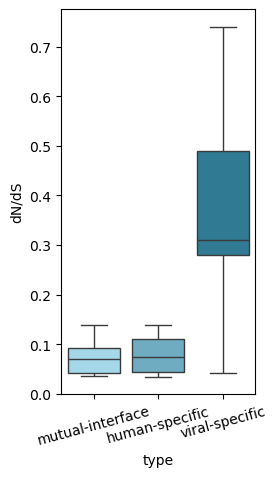

In [117]:
# create the boxplot
plt.figure(figsize=(2.5, 5))

colors = [ '#1f82a3' , '#61b3cf' , '#98def5' ]
sns.boxplot(x='type', y='dN/dS', hue= 'type', data=df_col_melted, showfliers=False, palette=colors , order = ['mutual-interface' , 'human-specific', 'viral-specific' ] )
plt.xticks(rotation=15)

plt.show()

In [105]:
statistic, p_value = stats.mannwhitneyu(m_col_list, h_col_list, alternative='less')
print(p_value)

0.07367148528886384


In [106]:
statistic, p_value = stats.mannwhitneyu(m_col_list, v_col_list, alternative='less')
print(p_value)

0.0026001816755814


In [109]:
rejected, pvals_corrected, _, _ = multipletests([0.07367148528886384 , 0.0026001816755814], alpha=0.05, method='fdr_bh')

In [110]:
pvals_corrected

array([0.07367149, 0.00520036])